In [118]:
import os
import re
import sys
import json
import spotipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from validclust import dunn
from sklearn.manifold import TSNE
from sklearn.dummy import DummyRegressor
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth
from sklearn.cluster import AgglomerativeClustering, AffinityPropagation, SpectralClustering, DBSCAN, OPTICS, Birch, KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, silhouette_score, pairwise_distances, davies_bouldin_score, calinski_harabasz_score


# warnings.filterwarnings("ignore")

In [2]:
# Credentials
os.environ["SPOTIPY_CLIENT_ID"] = "e93bb9b7b8aa4ba8a817537a0f7696f8"
os.environ["SPOTIPY_CLIENT_SECRET"] = "bd54ecc86e3b4bc08b33f3bed6e89dee"
os.environ['SPOTIPY_REDIRECT_URI'] = "http://localhost:8080"   # Needed for user authorization

# Defining scope to read user playlist and write playlist to user
scope = 'user-library-read user-follow-read playlist-modify-private playlist-modify'
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

In [3]:
df = pd.read_csv('data/Playlist_Feats.csv')
df

,name,pid,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Throwbacks,0,0.664077,0.781077,5.038462,-4.891212,0.692308,0.103698,0.083674,0.000674,0.187087,0.642750,121.157500,221777.461538,4.000000
1,Awesome Playlist,1,0.492382,0.695923,4.461538,-8.107974,0.538462,0.091010,0.162227,0.223708,0.179344,0.476667,124.987128,298837.641026,3.769231
2,korean,2,0.671062,0.692953,5.000000,-4.875594,0.515625,0.096425,0.269100,0.000638,0.168894,0.565078,114.595984,219373.953125,4.000000
3,mat,3,0.514349,0.620901,5.103175,-9.618754,0.714286,0.067004,0.273514,0.203148,0.188278,0.451258,125.523048,229575.055556,3.952381
4,90s,4,0.576235,0.650418,3.352941,-7.634529,0.823529,0.041218,0.177189,0.081759,0.166524,0.490294,127.725412,255014.352941,3.941176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,gang gang,115995,0.804615,0.529026,4.205128,-8.164179,0.589744,0.219638,0.217947,0.008621,0.166574,0.363818,129.452256,230348.358974,4.000000
19996,Chaos,115996,0.688900,0.695500,5.700000,-8.232650,0.400000,0.104215,0.243258,0.225892,0.151770,0.717800,135.314300,283091.000000,4.050000
19997,Spring 2014,115997,0.646571,0.603214,5.357143,-6.890929,0.714286,0.078743,0.227477,0.024347,0.146629,0.442571,125.139071,268988.928571,4.000000
19998,autumn,115998,0.549943,0.562457,5.114286,-8.666057,0.657143,0.065520,0.273361,0.018066,0.161580,0.390406,114.144886,237814.542857,3.971429


In [4]:
# Get all favorite songs from current user and save them to lists to construct dataframe
tracks = sp.current_user_saved_tracks()

song = []
artist = []
uri = []

#First pass of the saved tracks
for i in tracks['items']:
    song.append(i['track']['name'])
    artist.append(i['track']['artists'][0]['name'])
    uri_id = i['track']['uri']
    uri.append(re.search('(^spotify:track:([^\s]+))', uri_id).groups()[1])

# Keep looking in tracks for the rest of the saved tracks, they are paginated
while tracks['next']:
    tracks = sp.next(tracks)
    for i in tracks['items']:
        song.append(i['track']['name'])
        artist.append(i['track']['artists'][0]['name'])
        uri_id = i['track']['uri']
        uri.append(re.search('(^spotify:track:([^\s]+))', uri_id).groups()[1])

# Create a dataframe from info extracted above, song, artist and uri
fav_songs_df = pd.DataFrame(
    {'song': song,
     'artist': artist,
     'uri': uri
    })
fav_songs_df.head()

,song,artist,uri
0,Bendita Diabla - Apaga La Luz,E-Lhoy,0OxR238zEmOy20sSBbHgyK
1,Sinnerman - Sofi Tukker Remix,Nina Simone,6Au1l0egQFYxbnCZxakoOL
2,Lied vom Scheitern,Die Ärzte,3PUryKL6Jme3BlX95tutYn
3,Junge,Die Ärzte,10waMsh44ojvTwXAIy213n
4,Müssen nur wollen,Wir Sind Helden,1e79l5iRNvf4q9YXjt1Mn8


In [5]:
# Extract audio features from each song and create a dataframe
appended_df = []
for i in uri:
    appended_df.append(pd.DataFrame(sp.audio_features(i)[0], index=[i,]))
uri_df = pd.concat(appended_df)
uri_df = uri_df.drop(['uri'], axis=1)
uri_df = uri_df.reset_index()
uri_df = uri_df.rename(columns={"index": "uri"})

fav_songs_feats_df = pd.merge(fav_songs_df, uri_df, on="uri")
fav_songs_feats_df.head()

,song,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,track_href,analysis_url,duration_ms,time_signature
0,Bendita Diabla - Apaga La Luz,E-Lhoy,0OxR238zEmOy20sSBbHgyK,0.714,0.535,1,-7.149,0,0.0549,0.54500,0.000000,0.0859,0.619,130.045,audio_features,0OxR238zEmOy20sSBbHgyK,https://api.spotify.com/v1/tracks/0OxR238zEmOy...,https://api.spotify.com/v1/audio-analysis/0OxR...,210000,4
1,Sinnerman - Sofi Tukker Remix,Nina Simone,6Au1l0egQFYxbnCZxakoOL,0.795,0.764,11,-7.463,0,0.0400,0.41100,0.010500,0.0912,0.156,124.027,audio_features,6Au1l0egQFYxbnCZxakoOL,https://api.spotify.com/v1/tracks/6Au1l0egQFYx...,https://api.spotify.com/v1/audio-analysis/6Au1...,232632,4
2,Lied vom Scheitern,Die Ärzte,3PUryKL6Jme3BlX95tutYn,0.523,0.971,3,-4.683,1,0.0988,0.00313,0.000002,0.3800,0.381,144.956,audio_features,3PUryKL6Jme3BlX95tutYn,https://api.spotify.com/v1/tracks/3PUryKL6Jme3...,https://api.spotify.com/v1/audio-analysis/3PUr...,209187,4
3,Junge,Die Ärzte,10waMsh44ojvTwXAIy213n,0.563,0.792,10,-4.885,0,0.0350,0.05320,0.000003,0.1070,0.176,105.463,audio_features,10waMsh44ojvTwXAIy213n,https://api.spotify.com/v1/tracks/10waMsh44ojv...,https://api.spotify.com/v1/audio-analysis/10wa...,187533,4
4,Müssen nur wollen,Wir Sind Helden,1e79l5iRNvf4q9YXjt1Mn8,0.706,0.672,4,-3.903,1,0.0296,0.11300,0.000000,0.1670,0.829,125.941,audio_features,1e79l5iRNvf4q9YXjt1Mn8,https://api.spotify.com/v1/tracks/1e79l5iRNvf4...,https://api.spotify.com/v1/audio-analysis/1e79...,215747,4


In [6]:
feat_cols = ['pid','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
            'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']
feat_cols_user = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
            'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

# Playlists as Features

In [9]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
name,Throwbacks,Awesome Playlist,korean,mat,90s,Wedding,I Put A Spell On You,2017,BOP,old country,...,ambient,werk,Noosa Tastiest Playlist,new jams,SUMMER,gang gang,Chaos,Spring 2014,autumn,ChIlL
pid,0,1,2,3,4,5,6,7,8,9,...,115990,115991,115992,115993,115994,115995,115996,115997,115998,115999
danceability,0.664077,0.492382,0.671062,0.514349,0.576235,0.683625,0.50525,0.647113,0.512457,0.612571,...,0.684375,0.600481,0.566862,0.688,0.65725,0.804615,0.6889,0.646571,0.549943,0.680809
energy,0.781077,0.695923,0.692953,0.620901,0.650418,0.7176,0.777813,0.576245,0.685761,0.632619,...,0.55475,0.716779,0.62631,0.64356,0.551619,0.529026,0.6955,0.603214,0.562457,0.576838
key,5.03846,4.46154,5,5.10317,3.35294,4.5875,4.3125,4.83019,5.52174,5.66667,...,5.25,4.42857,5.37931,3.76,5.28125,4.20513,5.7,5.35714,5.11429,5.13971
loudness,-4.89121,-8.10797,-4.87559,-9.61875,-7.63453,-5.88374,-6.62081,-7.81357,-6.39304,-8.44276,...,-8.76819,-6.33,-7.23224,-6.43832,-9.99009,-8.16418,-8.23265,-6.89093,-8.66606,-6.65765
mode,0.692308,0.538462,0.515625,0.714286,0.823529,0.7375,0.8125,0.339623,0.717391,0.761905,...,0.25,0.727273,0.586207,0.72,0.75,0.589744,0.4,0.714286,0.657143,0.625
speechiness,0.103698,0.0910103,0.096425,0.067004,0.0412176,0.0762063,0.0467562,0.0760321,0.0502891,0.0494429,...,0.12685,0.0676909,0.0385897,0.090472,0.0551281,0.219638,0.104215,0.0787429,0.06552,0.121825
acousticness,0.0836741,0.162227,0.2691,0.273514,0.177189,0.115956,0.0639682,0.318786,0.178996,0.322338,...,0.341339,0.128716,0.298897,0.280103,0.376129,0.217947,0.243258,0.227477,0.273361,0.25882
instrumentalness,0.000674382,0.223708,0.000637812,0.203148,0.0817588,0.000628289,0.065451,0.0762201,0.057182,0.00322941,...,0.24426,0.0626846,0.253533,0.0478552,0.203212,0.00862146,0.225892,0.0243475,0.0180656,0.00293623


In [10]:
# Transpose df to have playlists as features - This is going to be X
X = df[feat_cols].set_index('pid').T
# Mean of the features of the user's fav songs - This is going to be y
y = fav_songs_feats_df[feat_cols_user].mean()

# Split data for training and testing
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, random_state=0)

X_train = StandardScaler().fit_transform(X_train_raw)
X_test  = StandardScaler().fit_transform(X_test_raw)

In [11]:
# Dummy classifiers to check against real classifier
dummy_A = DummyRegressor(strategy = 'mean').fit(X_train, y_train)
dummy_B = DummyRegressor(strategy = 'median').fit(X_train, y_train)

y_dummy_A_predictions = dummy_A.predict(X_test)
y_dummy_B_predictions = dummy_B.predict(X_test)

R2_A = dummy_A.score(X_test, y_test)
RMSE_A = mean_squared_error(y_test, y_dummy_A_predictions, squared=False)
MAE_A = mean_absolute_error(y_test, y_dummy_A_predictions)

R2_B = dummy_A.score(X_test, y_test)
RMSE_B = mean_squared_error(y_test, y_dummy_B_predictions, squared=False)
MAE_B = mean_absolute_error(y_test, y_dummy_A_predictions)

print('Dummy Regressor A Scores (Mean)')
print('R2: {}'.format(R2_A))
print('RMSE:    {}'.format(RMSE_A))
print('MAE:  {}\n'.format(MAE_A))

print('Dummy Regressor B Scores (Median)')
print('R2: {}'.format(R2_B))
print('RMSE:    {}'.format(RMSE_B))
print('MAE:  {}'.format(MAE_B))

Dummy Regressor A Scores (Mean)
R2: -0.33379879043333927
RMSE:    115614.31919372884
MAE:  57837.58011264492

Dummy Regressor B Scores (Median)
R2: -0.33379879043333927
RMSE:    115614.30693666621
MAE:  57837.58011264492


In [12]:
models = [LinearRegression(), Lasso()]

In [13]:
reg = LinearRegression().fit(X, y)
print(reg)
print('R2: {}'.format((reg.score(X, y))))
y_pred = reg.predict(X)
print('RMSE: {}'.format(mean_squared_error(y, y_pred, squared=False)))
print('MAE: {}'.format(mean_absolute_error(y, y_pred)))

importance = reg.coef_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

LinearRegression()
R2: 1.0
RMSE: 8.112266718761671e-11
MAE: 4.686397850980265e-11
Feature: 0, Score: 0.00009
Feature: 1, Score: 0.00005
Feature: 2, Score: 0.00012
Feature: 3, Score: 0.00003
Feature: 4, Score: 0.00009
Feature: 5, Score: 0.00010
Feature: 6, Score: 0.00006
Feature: 7, Score: 0.00011
Feature: 8, Score: 0.00004
Feature: 9, Score: 0.00008
Feature: 10, Score: -0.00000
Feature: 11, Score: 0.00009
Feature: 12, Score: 0.00006
Feature: 13, Score: -0.00001
Feature: 14, Score: 0.00004
Feature: 15, Score: 0.00014
Feature: 16, Score: 0.00006
Feature: 17, Score: 0.00009
Feature: 18, Score: 0.00006
Feature: 19, Score: 0.00005
Feature: 20, Score: -0.00003
Feature: 21, Score: 0.00002
Feature: 22, Score: 0.00007
Feature: 23, Score: 0.00004
Feature: 24, Score: 0.00002
Feature: 25, Score: 0.00012
Feature: 26, Score: 0.00006
Feature: 27, Score: 0.00005
Feature: 28, Score: 0.00001
Feature: 29, Score: 0.00007
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00013
Feature: 32, Score: 0.00008
F

Feature: 1391, Score: 0.00009
Feature: 1392, Score: 0.00005
Feature: 1393, Score: -0.00012
Feature: 1394, Score: -0.00007
Feature: 1395, Score: 0.00000
Feature: 1396, Score: -0.00003
Feature: 1397, Score: 0.00015
Feature: 1398, Score: 0.00017
Feature: 1399, Score: 0.00013
Feature: 1400, Score: 0.00001
Feature: 1401, Score: 0.00014
Feature: 1402, Score: -0.00003
Feature: 1403, Score: -0.00005
Feature: 1404, Score: 0.00000
Feature: 1405, Score: 0.00004
Feature: 1406, Score: -0.00002
Feature: 1407, Score: 0.00002
Feature: 1408, Score: -0.00001
Feature: 1409, Score: 0.00005
Feature: 1410, Score: 0.00007
Feature: 1411, Score: 0.00006
Feature: 1412, Score: 0.00008
Feature: 1413, Score: 0.00004
Feature: 1414, Score: 0.00009
Feature: 1415, Score: 0.00008
Feature: 1416, Score: 0.00011
Feature: 1417, Score: 0.00019
Feature: 1418, Score: -0.00003
Feature: 1419, Score: 0.00005
Feature: 1420, Score: 0.00004
Feature: 1421, Score: 0.00003
Feature: 1422, Score: 0.00007
Feature: 1423, Score: -0.00005
F

Feature: 2685, Score: 0.00005
Feature: 2686, Score: -0.00013
Feature: 2687, Score: 0.00008
Feature: 2688, Score: 0.00003
Feature: 2689, Score: 0.00005
Feature: 2690, Score: 0.00012
Feature: 2691, Score: -0.00001
Feature: 2692, Score: 0.00013
Feature: 2693, Score: 0.00004
Feature: 2694, Score: 0.00001
Feature: 2695, Score: 0.00007
Feature: 2696, Score: 0.00007
Feature: 2697, Score: 0.00003
Feature: 2698, Score: 0.00006
Feature: 2699, Score: 0.00003
Feature: 2700, Score: 0.00012
Feature: 2701, Score: 0.00003
Feature: 2702, Score: 0.00010
Feature: 2703, Score: 0.00011
Feature: 2704, Score: 0.00009
Feature: 2705, Score: 0.00011
Feature: 2706, Score: -0.00002
Feature: 2707, Score: 0.00005
Feature: 2708, Score: 0.00001
Feature: 2709, Score: 0.00012
Feature: 2710, Score: 0.00007
Feature: 2711, Score: 0.00007
Feature: 2712, Score: 0.00006
Feature: 2713, Score: 0.00003
Feature: 2714, Score: 0.00007
Feature: 2715, Score: 0.00008
Feature: 2716, Score: -0.00002
Feature: 2717, Score: 0.00008
Featur

Feature: 3890, Score: 0.00001
Feature: 3891, Score: 0.00011
Feature: 3892, Score: 0.00015
Feature: 3893, Score: 0.00001
Feature: 3894, Score: 0.00006
Feature: 3895, Score: 0.00007
Feature: 3896, Score: 0.00008
Feature: 3897, Score: 0.00018
Feature: 3898, Score: 0.00000
Feature: 3899, Score: 0.00014
Feature: 3900, Score: 0.00003
Feature: 3901, Score: 0.00002
Feature: 3902, Score: -0.00007
Feature: 3903, Score: 0.00007
Feature: 3904, Score: -0.00001
Feature: 3905, Score: 0.00007
Feature: 3906, Score: -0.00000
Feature: 3907, Score: 0.00002
Feature: 3908, Score: -0.00001
Feature: 3909, Score: 0.00018
Feature: 3910, Score: 0.00008
Feature: 3911, Score: -0.00002
Feature: 3912, Score: 0.00012
Feature: 3913, Score: 0.00009
Feature: 3914, Score: 0.00012
Feature: 3915, Score: 0.00003
Feature: 3916, Score: 0.00012
Feature: 3917, Score: 0.00012
Feature: 3918, Score: 0.00007
Feature: 3919, Score: -0.00000
Feature: 3920, Score: 0.00006
Feature: 3921, Score: 0.00007
Feature: 3922, Score: 0.00010
Feat

Feature: 5337, Score: -0.00001
Feature: 5338, Score: -0.00002
Feature: 5339, Score: 0.00013
Feature: 5340, Score: 0.00004
Feature: 5341, Score: 0.00002
Feature: 5342, Score: 0.00003
Feature: 5343, Score: 0.00007
Feature: 5344, Score: 0.00006
Feature: 5345, Score: 0.00006
Feature: 5346, Score: 0.00014
Feature: 5347, Score: 0.00020
Feature: 5348, Score: -0.00000
Feature: 5349, Score: 0.00010
Feature: 5350, Score: 0.00008
Feature: 5351, Score: 0.00009
Feature: 5352, Score: 0.00014
Feature: 5353, Score: 0.00000
Feature: 5354, Score: 0.00012
Feature: 5355, Score: 0.00005
Feature: 5356, Score: 0.00005
Feature: 5357, Score: 0.00003
Feature: 5358, Score: 0.00006
Feature: 5359, Score: 0.00003
Feature: 5360, Score: 0.00004
Feature: 5361, Score: 0.00004
Feature: 5362, Score: 0.00002
Feature: 5363, Score: 0.00004
Feature: 5364, Score: -0.00002
Feature: 5365, Score: 0.00005
Feature: 5366, Score: -0.00000
Feature: 5367, Score: 0.00003
Feature: 5368, Score: 0.00015
Feature: 5369, Score: -0.00001
Feat

Feature: 6389, Score: 0.00008
Feature: 6390, Score: 0.00008
Feature: 6391, Score: 0.00002
Feature: 6392, Score: -0.00006
Feature: 6393, Score: 0.00010
Feature: 6394, Score: 0.00004
Feature: 6395, Score: 0.00009
Feature: 6396, Score: 0.00011
Feature: 6397, Score: 0.00002
Feature: 6398, Score: 0.00007
Feature: 6399, Score: 0.00009
Feature: 6400, Score: -0.00003
Feature: 6401, Score: 0.00001
Feature: 6402, Score: 0.00009
Feature: 6403, Score: 0.00014
Feature: 6404, Score: 0.00011
Feature: 6405, Score: 0.00008
Feature: 6406, Score: -0.00001
Feature: 6407, Score: 0.00012
Feature: 6408, Score: 0.00007
Feature: 6409, Score: 0.00006
Feature: 6410, Score: 0.00001
Feature: 6411, Score: 0.00009
Feature: 6412, Score: -0.00008
Feature: 6413, Score: -0.00005
Feature: 6414, Score: -0.00001
Feature: 6415, Score: 0.00003
Feature: 6416, Score: 0.00003
Feature: 6417, Score: 0.00008
Feature: 6418, Score: -0.00004
Feature: 6419, Score: 0.00007
Feature: 6420, Score: -0.00002
Feature: 6421, Score: 0.00009
Fe

Feature: 7889, Score: 0.00001
Feature: 7890, Score: 0.00007
Feature: 7891, Score: -0.00007
Feature: 7892, Score: 0.00011
Feature: 7893, Score: 0.00007
Feature: 7894, Score: 0.00002
Feature: 7895, Score: 0.00008
Feature: 7896, Score: -0.00004
Feature: 7897, Score: 0.00006
Feature: 7898, Score: -0.00001
Feature: 7899, Score: 0.00006
Feature: 7900, Score: 0.00012
Feature: 7901, Score: 0.00007
Feature: 7902, Score: 0.00005
Feature: 7903, Score: 0.00004
Feature: 7904, Score: 0.00007
Feature: 7905, Score: 0.00004
Feature: 7906, Score: 0.00016
Feature: 7907, Score: -0.00002
Feature: 7908, Score: 0.00005
Feature: 7909, Score: -0.00012
Feature: 7910, Score: 0.00012
Feature: 7911, Score: 0.00001
Feature: 7912, Score: -0.00000
Feature: 7913, Score: 0.00005
Feature: 7914, Score: -0.00002
Feature: 7915, Score: 0.00007
Feature: 7916, Score: 0.00003
Feature: 7917, Score: 0.00007
Feature: 7918, Score: 0.00007
Feature: 7919, Score: 0.00005
Feature: 7920, Score: 0.00007
Feature: 7921, Score: 0.00008
Fea

Feature: 8888, Score: 0.00008
Feature: 8889, Score: 0.00002
Feature: 8890, Score: 0.00004
Feature: 8891, Score: 0.00007
Feature: 8892, Score: 0.00008
Feature: 8893, Score: 0.00003
Feature: 8894, Score: -0.00003
Feature: 8895, Score: 0.00008
Feature: 8896, Score: 0.00001
Feature: 8897, Score: 0.00016
Feature: 8898, Score: 0.00007
Feature: 8899, Score: 0.00011
Feature: 8900, Score: 0.00017
Feature: 8901, Score: 0.00003
Feature: 8902, Score: 0.00009
Feature: 8903, Score: -0.00004
Feature: 8904, Score: 0.00004
Feature: 8905, Score: 0.00007
Feature: 8906, Score: 0.00006
Feature: 8907, Score: 0.00008
Feature: 8908, Score: 0.00004
Feature: 8909, Score: 0.00009
Feature: 8910, Score: 0.00010
Feature: 8911, Score: 0.00008
Feature: 8912, Score: 0.00010
Feature: 8913, Score: -0.00003
Feature: 8914, Score: 0.00003
Feature: 8915, Score: 0.00008
Feature: 8916, Score: 0.00008
Feature: 8917, Score: -0.00009
Feature: 8918, Score: 0.00006
Feature: 8919, Score: -0.00000
Feature: 8920, Score: 0.00008
Featu

Feature: 10186, Score: 0.00017
Feature: 10187, Score: 0.00007
Feature: 10188, Score: 0.00010
Feature: 10189, Score: 0.00007
Feature: 10190, Score: 0.00008
Feature: 10191, Score: 0.00004
Feature: 10192, Score: -0.00008
Feature: 10193, Score: 0.00001
Feature: 10194, Score: 0.00007
Feature: 10195, Score: 0.00002
Feature: 10196, Score: 0.00010
Feature: 10197, Score: 0.00007
Feature: 10198, Score: 0.00004
Feature: 10199, Score: 0.00008
Feature: 10200, Score: -0.00004
Feature: 10201, Score: 0.00003
Feature: 10202, Score: 0.00005
Feature: 10203, Score: 0.00003
Feature: 10204, Score: 0.00012
Feature: 10205, Score: 0.00008
Feature: 10206, Score: -0.00001
Feature: 10207, Score: 0.00008
Feature: 10208, Score: -0.00004
Feature: 10209, Score: 0.00004
Feature: 10210, Score: 0.00010
Feature: 10211, Score: 0.00015
Feature: 10212, Score: -0.00002
Feature: 10213, Score: -0.00000
Feature: 10214, Score: 0.00007
Feature: 10215, Score: 0.00001
Feature: 10216, Score: 0.00004
Feature: 10217, Score: 0.00013
Fe

Feature: 11387, Score: -0.00003
Feature: 11388, Score: 0.00007
Feature: 11389, Score: 0.00003
Feature: 11390, Score: 0.00006
Feature: 11391, Score: -0.00000
Feature: 11392, Score: -0.00001
Feature: 11393, Score: -0.00005
Feature: 11394, Score: 0.00004
Feature: 11395, Score: 0.00004
Feature: 11396, Score: -0.00005
Feature: 11397, Score: 0.00005
Feature: 11398, Score: 0.00010
Feature: 11399, Score: 0.00009
Feature: 11400, Score: -0.00008
Feature: 11401, Score: 0.00002
Feature: 11402, Score: 0.00001
Feature: 11403, Score: 0.00012
Feature: 11404, Score: -0.00001
Feature: 11405, Score: 0.00014
Feature: 11406, Score: 0.00007
Feature: 11407, Score: 0.00005
Feature: 11408, Score: 0.00000
Feature: 11409, Score: 0.00013
Feature: 11410, Score: 0.00008
Feature: 11411, Score: 0.00008
Feature: 11412, Score: 0.00018
Feature: 11413, Score: -0.00007
Feature: 11414, Score: 0.00001
Feature: 11415, Score: 0.00002
Feature: 11416, Score: 0.00010
Feature: 11417, Score: 0.00010
Feature: 11418, Score: -0.00005

Feature: 12887, Score: 0.00006
Feature: 12888, Score: 0.00013
Feature: 12889, Score: 0.00004
Feature: 12890, Score: -0.00001
Feature: 12891, Score: 0.00008
Feature: 12892, Score: 0.00008
Feature: 12893, Score: -0.00005
Feature: 12894, Score: 0.00005
Feature: 12895, Score: 0.00007
Feature: 12896, Score: 0.00005
Feature: 12897, Score: 0.00008
Feature: 12898, Score: 0.00011
Feature: 12899, Score: -0.00003
Feature: 12900, Score: 0.00008
Feature: 12901, Score: 0.00007
Feature: 12902, Score: -0.00005
Feature: 12903, Score: 0.00003
Feature: 12904, Score: 0.00011
Feature: 12905, Score: -0.00003
Feature: 12906, Score: 0.00006
Feature: 12907, Score: 0.00005
Feature: 12908, Score: 0.00012
Feature: 12909, Score: 0.00012
Feature: 12910, Score: 0.00005
Feature: 12911, Score: 0.00006
Feature: 12912, Score: 0.00007
Feature: 12913, Score: 0.00000
Feature: 12914, Score: 0.00007
Feature: 12915, Score: 0.00005
Feature: 12916, Score: -0.00003
Feature: 12917, Score: 0.00005
Feature: 12918, Score: 0.00007
Fe

Feature: 14386, Score: 0.00007
Feature: 14387, Score: 0.00004
Feature: 14388, Score: 0.00008
Feature: 14389, Score: 0.00006
Feature: 14390, Score: 0.00006
Feature: 14391, Score: 0.00005
Feature: 14392, Score: 0.00009
Feature: 14393, Score: 0.00007
Feature: 14394, Score: 0.00010
Feature: 14395, Score: -0.00004
Feature: 14396, Score: 0.00003
Feature: 14397, Score: 0.00010
Feature: 14398, Score: 0.00010
Feature: 14399, Score: 0.00004
Feature: 14400, Score: 0.00004
Feature: 14401, Score: 0.00008
Feature: 14402, Score: 0.00015
Feature: 14403, Score: -0.00003
Feature: 14404, Score: 0.00010
Feature: 14405, Score: 0.00005
Feature: 14406, Score: 0.00014
Feature: 14407, Score: 0.00006
Feature: 14408, Score: 0.00010
Feature: 14409, Score: 0.00006
Feature: 14410, Score: 0.00007
Feature: 14411, Score: 0.00004
Feature: 14412, Score: 0.00008
Feature: 14413, Score: 0.00010
Feature: 14414, Score: 0.00007
Feature: 14415, Score: 0.00005
Feature: 14416, Score: 0.00004
Feature: 14417, Score: 0.00000
Featur

Feature: 15654, Score: 0.00008
Feature: 15655, Score: 0.00004
Feature: 15656, Score: 0.00005
Feature: 15657, Score: 0.00002
Feature: 15658, Score: 0.00013
Feature: 15659, Score: -0.00004
Feature: 15660, Score: 0.00015
Feature: 15661, Score: 0.00005
Feature: 15662, Score: -0.00000
Feature: 15663, Score: -0.00001
Feature: 15664, Score: 0.00012
Feature: 15665, Score: 0.00003
Feature: 15666, Score: 0.00006
Feature: 15667, Score: -0.00001
Feature: 15668, Score: 0.00015
Feature: 15669, Score: 0.00009
Feature: 15670, Score: 0.00017
Feature: 15671, Score: 0.00003
Feature: 15672, Score: 0.00009
Feature: 15673, Score: 0.00007
Feature: 15674, Score: -0.00005
Feature: 15675, Score: 0.00002
Feature: 15676, Score: 0.00005
Feature: 15677, Score: 0.00001
Feature: 15678, Score: 0.00008
Feature: 15679, Score: 0.00021
Feature: 15680, Score: 0.00006
Feature: 15681, Score: 0.00009
Feature: 15682, Score: 0.00001
Feature: 15683, Score: 0.00008
Feature: 15684, Score: 0.00006
Feature: 15685, Score: 0.00008
Fea

Feature: 16885, Score: 0.00003
Feature: 16886, Score: 0.00004
Feature: 16887, Score: 0.00002
Feature: 16888, Score: 0.00002
Feature: 16889, Score: 0.00008
Feature: 16890, Score: 0.00003
Feature: 16891, Score: 0.00002
Feature: 16892, Score: 0.00005
Feature: 16893, Score: 0.00006
Feature: 16894, Score: 0.00011
Feature: 16895, Score: 0.00001
Feature: 16896, Score: -0.00003
Feature: 16897, Score: 0.00007
Feature: 16898, Score: 0.00003
Feature: 16899, Score: 0.00003
Feature: 16900, Score: 0.00009
Feature: 16901, Score: 0.00004
Feature: 16902, Score: 0.00009
Feature: 16903, Score: 0.00007
Feature: 16904, Score: 0.00000
Feature: 16905, Score: 0.00005
Feature: 16906, Score: 0.00005
Feature: 16907, Score: 0.00008
Feature: 16908, Score: 0.00003
Feature: 16909, Score: 0.00008
Feature: 16910, Score: 0.00010
Feature: 16911, Score: 0.00006
Feature: 16912, Score: 0.00007
Feature: 16913, Score: 0.00005
Feature: 16914, Score: 0.00007
Feature: 16915, Score: 0.00007
Feature: 16916, Score: -0.00009
Featur

Feature: 18385, Score: 0.00007
Feature: 18386, Score: 0.00002
Feature: 18387, Score: -0.00002
Feature: 18388, Score: -0.00008
Feature: 18389, Score: 0.00001
Feature: 18390, Score: 0.00009
Feature: 18391, Score: 0.00010
Feature: 18392, Score: 0.00005
Feature: 18393, Score: 0.00001
Feature: 18394, Score: 0.00007
Feature: 18395, Score: 0.00007
Feature: 18396, Score: -0.00003
Feature: 18397, Score: 0.00009
Feature: 18398, Score: 0.00005
Feature: 18399, Score: 0.00006
Feature: 18400, Score: 0.00003
Feature: 18401, Score: 0.00007
Feature: 18402, Score: 0.00005
Feature: 18403, Score: -0.00001
Feature: 18404, Score: 0.00009
Feature: 18405, Score: 0.00003
Feature: 18406, Score: 0.00010
Feature: 18407, Score: 0.00004
Feature: 18408, Score: 0.00008
Feature: 18409, Score: 0.00007
Feature: 18410, Score: 0.00007
Feature: 18411, Score: 0.00014
Feature: 18412, Score: 0.00005
Feature: 18413, Score: -0.00004
Feature: 18414, Score: 0.00005
Feature: 18415, Score: 0.00005
Feature: 18416, Score: 0.00003
Fea

Feature: 19884, Score: 0.00003
Feature: 19885, Score: 0.00004
Feature: 19886, Score: 0.00007
Feature: 19887, Score: 0.00007
Feature: 19888, Score: -0.00002
Feature: 19889, Score: 0.00016
Feature: 19890, Score: 0.00002
Feature: 19891, Score: 0.00009
Feature: 19892, Score: 0.00000
Feature: 19893, Score: 0.00004
Feature: 19894, Score: 0.00006
Feature: 19895, Score: 0.00009
Feature: 19896, Score: 0.00009
Feature: 19897, Score: 0.00006
Feature: 19898, Score: 0.00005
Feature: 19899, Score: 0.00009
Feature: 19900, Score: 0.00005
Feature: 19901, Score: 0.00005
Feature: 19902, Score: 0.00004
Feature: 19903, Score: 0.00010
Feature: 19904, Score: 0.00006
Feature: 19905, Score: 0.00008
Feature: 19906, Score: 0.00013
Feature: 19907, Score: -0.00001
Feature: 19908, Score: 0.00011
Feature: 19909, Score: 0.00005
Feature: 19910, Score: 0.00008
Feature: 19911, Score: 0.00010
Feature: 19912, Score: 0.00002
Feature: 19913, Score: 0.00016
Feature: 19914, Score: 0.00006
Feature: 19915, Score: 0.00004
Featur

In [14]:
from sklearn.ensemble.forest import RandomForestRegressor
# Can combine step above with this
forest = RandomForestRegressor(random_state=42, max_depth=5, max_features=10) 
forest.fit(X,y)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature rankings
print("Playlist ranking:")
  
for f in range(len(importances)):
    print("%d. %s %f " % (f + 1, 
            X.columns[f], 
            importances[indices[f]]))

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


Playlist ranking:
1. 0 0.010000 
2. 1 0.010000 
3. 2 0.010000 
4. 3 0.010000 
5. 4 0.010000 
6. 5 0.010000 
7. 6 0.010000 
8. 7 0.010000 
9. 8 0.010000 
10. 9 0.010000 
11. 10 0.010000 
12. 11 0.010000 
13. 12 0.010000 
14. 13 0.010000 
15. 14 0.010000 
16. 15 0.010000 
17. 16 0.010000 
18. 17 0.010000 
19. 18 0.010000 
20. 19 0.010000 
21. 20 0.010000 
22. 21 0.010000 
23. 22 0.010000 
24. 23 0.010000 
25. 24 0.010000 
26. 25 0.010000 
27. 26 0.010000 
28. 27 0.010000 
29. 28 0.010000 
30. 29 0.010000 
31. 30 0.010000 
32. 31 0.010000 
33. 32 0.010000 
34. 33 0.010000 
35. 34 0.010000 
36. 35 0.010000 
37. 36 0.010000 
38. 37 0.010000 
39. 38 0.010000 
40. 39 0.010000 
41. 40 0.010000 
42. 41 0.010000 
43. 42 0.010000 
44. 43 0.010000 
45. 44 0.010000 
46. 45 0.010000 
47. 46 0.010000 
48. 47 0.010000 
49. 48 0.010000 
50. 49 0.010000 
51. 50 0.010000 
52. 51 0.010000 
53. 52 0.010000 
54. 53 0.010000 
55. 54 0.010000 
56. 55 0.010000 
57. 56 0.010000 
58. 57 0.010000 
59. 58 0.010000

1861. 1860 0.000000 
1862. 1861 0.000000 
1863. 1862 0.000000 
1864. 1863 0.000000 
1865. 1864 0.000000 
1866. 1865 0.000000 
1867. 1866 0.000000 
1868. 1867 0.000000 
1869. 1868 0.000000 
1870. 1869 0.000000 
1871. 1870 0.000000 
1872. 1871 0.000000 
1873. 1872 0.000000 
1874. 1873 0.000000 
1875. 1874 0.000000 
1876. 1875 0.000000 
1877. 1876 0.000000 
1878. 1877 0.000000 
1879. 1878 0.000000 
1880. 1879 0.000000 
1881. 1880 0.000000 
1882. 1881 0.000000 
1883. 1882 0.000000 
1884. 1883 0.000000 
1885. 1884 0.000000 
1886. 1885 0.000000 
1887. 1886 0.000000 
1888. 1887 0.000000 
1889. 1888 0.000000 
1890. 1889 0.000000 
1891. 1890 0.000000 
1892. 1891 0.000000 
1893. 1892 0.000000 
1894. 1893 0.000000 
1895. 1894 0.000000 
1896. 1895 0.000000 
1897. 1896 0.000000 
1898. 1897 0.000000 
1899. 1898 0.000000 
1900. 1899 0.000000 
1901. 1900 0.000000 
1902. 1901 0.000000 
1903. 1902 0.000000 
1904. 1903 0.000000 
1905. 1904 0.000000 
1906. 1905 0.000000 
1907. 1906 0.000000 
1908. 1907 0.

2376. 10375 0.000000 
2377. 10376 0.000000 
2378. 10377 0.000000 
2379. 10378 0.000000 
2380. 10379 0.000000 
2381. 10380 0.000000 
2382. 10381 0.000000 
2383. 10382 0.000000 
2384. 10383 0.000000 
2385. 10384 0.000000 
2386. 10385 0.000000 
2387. 10386 0.000000 
2388. 10387 0.000000 
2389. 10388 0.000000 
2390. 10389 0.000000 
2391. 10390 0.000000 
2392. 10391 0.000000 
2393. 10392 0.000000 
2394. 10393 0.000000 
2395. 10394 0.000000 
2396. 10395 0.000000 
2397. 10396 0.000000 
2398. 10397 0.000000 
2399. 10398 0.000000 
2400. 10399 0.000000 
2401. 10400 0.000000 
2402. 10401 0.000000 
2403. 10402 0.000000 
2404. 10403 0.000000 
2405. 10404 0.000000 
2406. 10405 0.000000 
2407. 10406 0.000000 
2408. 10407 0.000000 
2409. 10408 0.000000 
2410. 10409 0.000000 
2411. 10410 0.000000 
2412. 10411 0.000000 
2413. 10412 0.000000 
2414. 10413 0.000000 
2415. 10414 0.000000 
2416. 10415 0.000000 
2417. 10416 0.000000 
2418. 10417 0.000000 
2419. 10418 0.000000 
2420. 10419 0.000000 
2421. 1042

3805. 100804 0.000000 
3806. 100805 0.000000 
3807. 100806 0.000000 
3808. 100807 0.000000 
3809. 100808 0.000000 
3810. 100809 0.000000 
3811. 100810 0.000000 
3812. 100811 0.000000 
3813. 100812 0.000000 
3814. 100813 0.000000 
3815. 100814 0.000000 
3816. 100815 0.000000 
3817. 100816 0.000000 
3818. 100817 0.000000 
3819. 100818 0.000000 
3820. 100819 0.000000 
3821. 100820 0.000000 
3822. 100821 0.000000 
3823. 100822 0.000000 
3824. 100823 0.000000 
3825. 100824 0.000000 
3826. 100825 0.000000 
3827. 100826 0.000000 
3828. 100827 0.000000 
3829. 100828 0.000000 
3830. 100829 0.000000 
3831. 100830 0.000000 
3832. 100831 0.000000 
3833. 100832 0.000000 
3834. 100833 0.000000 
3835. 100834 0.000000 
3836. 100835 0.000000 
3837. 100836 0.000000 
3838. 100837 0.000000 
3839. 100838 0.000000 
3840. 100839 0.000000 
3841. 100840 0.000000 
3842. 100841 0.000000 
3843. 100842 0.000000 
3844. 100843 0.000000 
3845. 100844 0.000000 
3846. 100845 0.000000 
3847. 100846 0.000000 
3848. 10084

4875. 101874 0.000000 
4876. 101875 0.000000 
4877. 101876 0.000000 
4878. 101877 0.000000 
4879. 101878 0.000000 
4880. 101879 0.000000 
4881. 101880 0.000000 
4882. 101881 0.000000 
4883. 101882 0.000000 
4884. 101883 0.000000 
4885. 101884 0.000000 
4886. 101885 0.000000 
4887. 101886 0.000000 
4888. 101887 0.000000 
4889. 101888 0.000000 
4890. 101889 0.000000 
4891. 101890 0.000000 
4892. 101891 0.000000 
4893. 101892 0.000000 
4894. 101893 0.000000 
4895. 101894 0.000000 
4896. 101895 0.000000 
4897. 101896 0.000000 
4898. 101897 0.000000 
4899. 101898 0.000000 
4900. 101899 0.000000 
4901. 101900 0.000000 
4902. 101901 0.000000 
4903. 101902 0.000000 
4904. 101903 0.000000 
4905. 101904 0.000000 
4906. 101905 0.000000 
4907. 101906 0.000000 
4908. 101907 0.000000 
4909. 101908 0.000000 
4910. 101909 0.000000 
4911. 101910 0.000000 
4912. 101911 0.000000 
4913. 101912 0.000000 
4914. 101913 0.000000 
4915. 101914 0.000000 
4916. 101915 0.000000 
4917. 101916 0.000000 
4918. 10191

6375. 103374 0.000000 
6376. 103375 0.000000 
6377. 103376 0.000000 
6378. 103377 0.000000 
6379. 103378 0.000000 
6380. 103379 0.000000 
6381. 103380 0.000000 
6382. 103381 0.000000 
6383. 103382 0.000000 
6384. 103383 0.000000 
6385. 103384 0.000000 
6386. 103385 0.000000 
6387. 103386 0.000000 
6388. 103387 0.000000 
6389. 103388 0.000000 
6390. 103389 0.000000 
6391. 103390 0.000000 
6392. 103391 0.000000 
6393. 103392 0.000000 
6394. 103393 0.000000 
6395. 103394 0.000000 
6396. 103395 0.000000 
6397. 103396 0.000000 
6398. 103397 0.000000 
6399. 103398 0.000000 
6400. 103399 0.000000 
6401. 103400 0.000000 
6402. 103401 0.000000 
6403. 103402 0.000000 
6404. 103403 0.000000 
6405. 103404 0.000000 
6406. 103405 0.000000 
6407. 103406 0.000000 
6408. 103407 0.000000 
6409. 103408 0.000000 
6410. 103409 0.000000 
6411. 103410 0.000000 
6412. 103411 0.000000 
6413. 103412 0.000000 
6414. 103413 0.000000 
6415. 103414 0.000000 
6416. 103415 0.000000 
6417. 103416 0.000000 
6418. 10341

7142. 104141 0.000000 
7143. 104142 0.000000 
7144. 104143 0.000000 
7145. 104144 0.000000 
7146. 104145 0.000000 
7147. 104146 0.000000 
7148. 104147 0.000000 
7149. 104148 0.000000 
7150. 104149 0.000000 
7151. 104150 0.000000 
7152. 104151 0.000000 
7153. 104152 0.000000 
7154. 104153 0.000000 
7155. 104154 0.000000 
7156. 104155 0.000000 
7157. 104156 0.000000 
7158. 104157 0.000000 
7159. 104158 0.000000 
7160. 104159 0.000000 
7161. 104160 0.000000 
7162. 104161 0.000000 
7163. 104162 0.000000 
7164. 104163 0.000000 
7165. 104164 0.000000 
7166. 104165 0.000000 
7167. 104166 0.000000 
7168. 104167 0.000000 
7169. 104168 0.000000 
7170. 104169 0.000000 
7171. 104170 0.000000 
7172. 104171 0.000000 
7173. 104172 0.000000 
7174. 104173 0.000000 
7175. 104174 0.000000 
7176. 104175 0.000000 
7177. 104176 0.000000 
7178. 104177 0.000000 
7179. 104178 0.000000 
7180. 104179 0.000000 
7181. 104180 0.000000 
7182. 104181 0.000000 
7183. 104182 0.000000 
7184. 104183 0.000000 
7185. 10418

8374. 105373 0.000000 
8375. 105374 0.000000 
8376. 105375 0.000000 
8377. 105376 0.000000 
8378. 105377 0.000000 
8379. 105378 0.000000 
8380. 105379 0.000000 
8381. 105380 0.000000 
8382. 105381 0.000000 
8383. 105382 0.000000 
8384. 105383 0.000000 
8385. 105384 0.000000 
8386. 105385 0.000000 
8387. 105386 0.000000 
8388. 105387 0.000000 
8389. 105388 0.000000 
8390. 105389 0.000000 
8391. 105390 0.000000 
8392. 105391 0.000000 
8393. 105392 0.000000 
8394. 105393 0.000000 
8395. 105394 0.000000 
8396. 105395 0.000000 
8397. 105396 0.000000 
8398. 105397 0.000000 
8399. 105398 0.000000 
8400. 105399 0.000000 
8401. 105400 0.000000 
8402. 105401 0.000000 
8403. 105402 0.000000 
8404. 105403 0.000000 
8405. 105404 0.000000 
8406. 105405 0.000000 
8407. 105406 0.000000 
8408. 105407 0.000000 
8409. 105408 0.000000 
8410. 105409 0.000000 
8411. 105410 0.000000 
8412. 105411 0.000000 
8413. 105412 0.000000 
8414. 105413 0.000000 
8415. 105414 0.000000 
8416. 105415 0.000000 
8417. 10541

9873. 106872 0.000000 
9874. 106873 0.000000 
9875. 106874 0.000000 
9876. 106875 0.000000 
9877. 106876 0.000000 
9878. 106877 0.000000 
9879. 106878 0.000000 
9880. 106879 0.000000 
9881. 106880 0.000000 
9882. 106881 0.000000 
9883. 106882 0.000000 
9884. 106883 0.000000 
9885. 106884 0.000000 
9886. 106885 0.000000 
9887. 106886 0.000000 
9888. 106887 0.000000 
9889. 106888 0.000000 
9890. 106889 0.000000 
9891. 106890 0.000000 
9892. 106891 0.000000 
9893. 106892 0.000000 
9894. 106893 0.000000 
9895. 106894 0.000000 
9896. 106895 0.000000 
9897. 106896 0.000000 
9898. 106897 0.000000 
9899. 106898 0.000000 
9900. 106899 0.000000 
9901. 106900 0.000000 
9902. 106901 0.000000 
9903. 106902 0.000000 
9904. 106903 0.000000 
9905. 106904 0.000000 
9906. 106905 0.000000 
9907. 106906 0.000000 
9908. 106907 0.000000 
9909. 106908 0.000000 
9910. 106909 0.000000 
9911. 106910 0.000000 
9912. 106911 0.000000 
9913. 106912 0.000000 
9914. 106913 0.000000 
9915. 106914 0.000000 
9916. 10691

11373. 108372 0.000000 
11374. 108373 0.000000 
11375. 108374 0.000000 
11376. 108375 0.000000 
11377. 108376 0.000000 
11378. 108377 0.000000 
11379. 108378 0.000000 
11380. 108379 0.000000 
11381. 108380 0.000000 
11382. 108381 0.000000 
11383. 108382 0.000000 
11384. 108383 0.000000 
11385. 108384 0.000000 
11386. 108385 0.000000 
11387. 108386 0.000000 
11388. 108387 0.000000 
11389. 108388 0.000000 
11390. 108389 0.000000 
11391. 108390 0.000000 
11392. 108391 0.000000 
11393. 108392 0.000000 
11394. 108393 0.000000 
11395. 108394 0.000000 
11396. 108395 0.000000 
11397. 108396 0.000000 
11398. 108397 0.000000 
11399. 108398 0.000000 
11400. 108399 0.000000 
11401. 108400 0.000000 
11402. 108401 0.000000 
11403. 108402 0.000000 
11404. 108403 0.000000 
11405. 108404 0.000000 
11406. 108405 0.000000 
11407. 108406 0.000000 
11408. 108407 0.000000 
11409. 108408 0.000000 
11410. 108409 0.000000 
11411. 108410 0.000000 
11412. 108411 0.000000 
11413. 108412 0.000000 
11414. 108413 0.

12872. 109871 0.000000 
12873. 109872 0.000000 
12874. 109873 0.000000 
12875. 109874 0.000000 
12876. 109875 0.000000 
12877. 109876 0.000000 
12878. 109877 0.000000 
12879. 109878 0.000000 
12880. 109879 0.000000 
12881. 109880 0.000000 
12882. 109881 0.000000 
12883. 109882 0.000000 
12884. 109883 0.000000 
12885. 109884 0.000000 
12886. 109885 0.000000 
12887. 109886 0.000000 
12888. 109887 0.000000 
12889. 109888 0.000000 
12890. 109889 0.000000 
12891. 109890 0.000000 
12892. 109891 0.000000 
12893. 109892 0.000000 
12894. 109893 0.000000 
12895. 109894 0.000000 
12896. 109895 0.000000 
12897. 109896 0.000000 
12898. 109897 0.000000 
12899. 109898 0.000000 
12900. 109899 0.000000 
12901. 109900 0.000000 
12902. 109901 0.000000 
12903. 109902 0.000000 
12904. 109903 0.000000 
12905. 109904 0.000000 
12906. 109905 0.000000 
12907. 109906 0.000000 
12908. 109907 0.000000 
12909. 109908 0.000000 
12910. 109909 0.000000 
12911. 109910 0.000000 
12912. 109911 0.000000 
12913. 109912 0.

13872. 11871 0.000000 
13873. 11872 0.000000 
13874. 11873 0.000000 
13875. 11874 0.000000 
13876. 11875 0.000000 
13877. 11876 0.000000 
13878. 11877 0.000000 
13879. 11878 0.000000 
13880. 11879 0.000000 
13881. 11880 0.000000 
13882. 11881 0.000000 
13883. 11882 0.000000 
13884. 11883 0.000000 
13885. 11884 0.000000 
13886. 11885 0.000000 
13887. 11886 0.000000 
13888. 11887 0.000000 
13889. 11888 0.000000 
13890. 11889 0.000000 
13891. 11890 0.000000 
13892. 11891 0.000000 
13893. 11892 0.000000 
13894. 11893 0.000000 
13895. 11894 0.000000 
13896. 11895 0.000000 
13897. 11896 0.000000 
13898. 11897 0.000000 
13899. 11898 0.000000 
13900. 11899 0.000000 
13901. 11900 0.000000 
13902. 11901 0.000000 
13903. 11902 0.000000 
13904. 11903 0.000000 
13905. 11904 0.000000 
13906. 11905 0.000000 
13907. 11906 0.000000 
13908. 11907 0.000000 
13909. 11908 0.000000 
13910. 11909 0.000000 
13911. 11910 0.000000 
13912. 11911 0.000000 
13913. 11912 0.000000 
13914. 11913 0.000000 
13915. 1191

14436. 110435 0.000000 
14437. 110436 0.000000 
14438. 110437 0.000000 
14439. 110438 0.000000 
14440. 110439 0.000000 
14441. 110440 0.000000 
14442. 110441 0.000000 
14443. 110442 0.000000 
14444. 110443 0.000000 
14445. 110444 0.000000 
14446. 110445 0.000000 
14447. 110446 0.000000 
14448. 110447 0.000000 
14449. 110448 0.000000 
14450. 110449 0.000000 
14451. 110450 0.000000 
14452. 110451 0.000000 
14453. 110452 0.000000 
14454. 110453 0.000000 
14455. 110454 0.000000 
14456. 110455 0.000000 
14457. 110456 0.000000 
14458. 110457 0.000000 
14459. 110458 0.000000 
14460. 110459 0.000000 
14461. 110460 0.000000 
14462. 110461 0.000000 
14463. 110462 0.000000 
14464. 110463 0.000000 
14465. 110464 0.000000 
14466. 110465 0.000000 
14467. 110466 0.000000 
14468. 110467 0.000000 
14469. 110468 0.000000 
14470. 110469 0.000000 
14471. 110470 0.000000 
14472. 110471 0.000000 
14473. 110472 0.000000 
14474. 110473 0.000000 
14475. 110474 0.000000 
14476. 110475 0.000000 
14477. 110476 0.

15371. 111370 0.000000 
15372. 111371 0.000000 
15373. 111372 0.000000 
15374. 111373 0.000000 
15375. 111374 0.000000 
15376. 111375 0.000000 
15377. 111376 0.000000 
15378. 111377 0.000000 
15379. 111378 0.000000 
15380. 111379 0.000000 
15381. 111380 0.000000 
15382. 111381 0.000000 
15383. 111382 0.000000 
15384. 111383 0.000000 
15385. 111384 0.000000 
15386. 111385 0.000000 
15387. 111386 0.000000 
15388. 111387 0.000000 
15389. 111388 0.000000 
15390. 111389 0.000000 
15391. 111390 0.000000 
15392. 111391 0.000000 
15393. 111392 0.000000 
15394. 111393 0.000000 
15395. 111394 0.000000 
15396. 111395 0.000000 
15397. 111396 0.000000 
15398. 111397 0.000000 
15399. 111398 0.000000 
15400. 111399 0.000000 
15401. 111400 0.000000 
15402. 111401 0.000000 
15403. 111402 0.000000 
15404. 111403 0.000000 
15405. 111404 0.000000 
15406. 111405 0.000000 
15407. 111406 0.000000 
15408. 111407 0.000000 
15409. 111408 0.000000 
15410. 111409 0.000000 
15411. 111410 0.000000 
15412. 111411 0.

16641. 112640 0.000000 
16642. 112641 0.000000 
16643. 112642 0.000000 
16644. 112643 0.000000 
16645. 112644 0.000000 
16646. 112645 0.000000 
16647. 112646 0.000000 
16648. 112647 0.000000 
16649. 112648 0.000000 
16650. 112649 0.000000 
16651. 112650 0.000000 
16652. 112651 0.000000 
16653. 112652 0.000000 
16654. 112653 0.000000 
16655. 112654 0.000000 
16656. 112655 0.000000 
16657. 112656 0.000000 
16658. 112657 0.000000 
16659. 112658 0.000000 
16660. 112659 0.000000 
16661. 112660 0.000000 
16662. 112661 0.000000 
16663. 112662 0.000000 
16664. 112663 0.000000 
16665. 112664 0.000000 
16666. 112665 0.000000 
16667. 112666 0.000000 
16668. 112667 0.000000 
16669. 112668 0.000000 
16670. 112669 0.000000 
16671. 112670 0.000000 
16672. 112671 0.000000 
16673. 112672 0.000000 
16674. 112673 0.000000 
16675. 112674 0.000000 
16676. 112675 0.000000 
16677. 112676 0.000000 
16678. 112677 0.000000 
16679. 112678 0.000000 
16680. 112679 0.000000 
16681. 112680 0.000000 
16682. 112681 0.

17202. 113201 0.000000 
17203. 113202 0.000000 
17204. 113203 0.000000 
17205. 113204 0.000000 
17206. 113205 0.000000 
17207. 113206 0.000000 
17208. 113207 0.000000 
17209. 113208 0.000000 
17210. 113209 0.000000 
17211. 113210 0.000000 
17212. 113211 0.000000 
17213. 113212 0.000000 
17214. 113213 0.000000 
17215. 113214 0.000000 
17216. 113215 0.000000 
17217. 113216 0.000000 
17218. 113217 0.000000 
17219. 113218 0.000000 
17220. 113219 0.000000 
17221. 113220 0.000000 
17222. 113221 0.000000 
17223. 113222 0.000000 
17224. 113223 0.000000 
17225. 113224 0.000000 
17226. 113225 0.000000 
17227. 113226 0.000000 
17228. 113227 0.000000 
17229. 113228 0.000000 
17230. 113229 0.000000 
17231. 113230 0.000000 
17232. 113231 0.000000 
17233. 113232 0.000000 
17234. 113233 0.000000 
17235. 113234 0.000000 
17236. 113235 0.000000 
17237. 113236 0.000000 
17238. 113237 0.000000 
17239. 113238 0.000000 
17240. 113239 0.000000 
17241. 113240 0.000000 
17242. 113241 0.000000 
17243. 113242 0.

17869. 113868 0.000000 
17870. 113869 0.000000 
17871. 113870 0.000000 
17872. 113871 0.000000 
17873. 113872 0.000000 
17874. 113873 0.000000 
17875. 113874 0.000000 
17876. 113875 0.000000 
17877. 113876 0.000000 
17878. 113877 0.000000 
17879. 113878 0.000000 
17880. 113879 0.000000 
17881. 113880 0.000000 
17882. 113881 0.000000 
17883. 113882 0.000000 
17884. 113883 0.000000 
17885. 113884 0.000000 
17886. 113885 0.000000 
17887. 113886 0.000000 
17888. 113887 0.000000 
17889. 113888 0.000000 
17890. 113889 0.000000 
17891. 113890 0.000000 
17892. 113891 0.000000 
17893. 113892 0.000000 
17894. 113893 0.000000 
17895. 113894 0.000000 
17896. 113895 0.000000 
17897. 113896 0.000000 
17898. 113897 0.000000 
17899. 113898 0.000000 
17900. 113899 0.000000 
17901. 113900 0.000000 
17902. 113901 0.000000 
17903. 113902 0.000000 
17904. 113903 0.000000 
17905. 113904 0.000000 
17906. 113905 0.000000 
17907. 113906 0.000000 
17908. 113907 0.000000 
17909. 113908 0.000000 
17910. 113909 0.

19220. 115219 0.000000 
19221. 115220 0.000000 
19222. 115221 0.000000 
19223. 115222 0.000000 
19224. 115223 0.000000 
19225. 115224 0.000000 
19226. 115225 0.000000 
19227. 115226 0.000000 
19228. 115227 0.000000 
19229. 115228 0.000000 
19230. 115229 0.000000 
19231. 115230 0.000000 
19232. 115231 0.000000 
19233. 115232 0.000000 
19234. 115233 0.000000 
19235. 115234 0.000000 
19236. 115235 0.000000 
19237. 115236 0.000000 
19238. 115237 0.000000 
19239. 115238 0.000000 
19240. 115239 0.000000 
19241. 115240 0.000000 
19242. 115241 0.000000 
19243. 115242 0.000000 
19244. 115243 0.000000 
19245. 115244 0.000000 
19246. 115245 0.000000 
19247. 115246 0.000000 
19248. 115247 0.000000 
19249. 115248 0.000000 
19250. 115249 0.000000 
19251. 115250 0.000000 
19252. 115251 0.000000 
19253. 115252 0.000000 
19254. 115253 0.000000 
19255. 115254 0.000000 
19256. 115255 0.000000 
19257. 115256 0.000000 
19258. 115257 0.000000 
19259. 115258 0.000000 
19260. 115259 0.000000 
19261. 115260 0.

# Unsupervised Approach

In [15]:
df.head()

,name,pid,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Throwbacks,0,0.664077,0.781077,5.038462,-4.891212,0.692308,0.103698,0.083674,0.000674,0.187087,0.642750,121.157500,221777.461538,4.000000
1,Awesome Playlist,1,0.492382,0.695923,4.461538,-8.107974,0.538462,0.091010,0.162227,0.223708,0.179344,0.476667,124.987128,298837.641026,3.769231
2,korean,2,0.671062,0.692953,5.000000,-4.875594,0.515625,0.096425,0.269100,0.000638,0.168894,0.565078,114.595984,219373.953125,4.000000
3,mat,3,0.514349,0.620901,5.103175,-9.618754,0.714286,0.067004,0.273514,0.203148,0.188278,0.451258,125.523048,229575.055556,3.952381
4,90s,4,0.576235,0.650418,3.352941,-7.634529,0.823529,0.041218,0.177189,0.081759,0.166524,0.490294,127.725412,255014.352941,3.941176


In [16]:
# feats_df = df[feat_cols_user]
scaler = StandardScaler(with_mean=True, with_std=True).fit(df[feat_cols_user])
scaled_data = scaler.transform(df[feat_cols_user])
scaled_y = scaler.transform(np.array(y).reshape(1,-1))
feats_df = pd.DataFrame(scaled_data)
feats_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.612856,1.087184,-0.201775,0.996660,0.208011,0.192259,-0.913576,-0.473002,-0.007089,1.210086,-0.020760,-0.385630,0.590494
1,-1.181611,0.440106,-1.061919,-0.305130,-0.779607,-0.032644,-0.456511,1.291821,-0.187318,-0.100881,0.497542,1.926104,-1.768360
2,0.685865,0.417537,-0.259118,1.002980,-0.926207,0.063337,0.165333,-0.473291,-0.430553,0.596989,-0.908796,-0.457733,0.590494
3,-0.952022,-0.129984,-0.105293,-0.916527,0.349099,-0.458178,0.191017,1.129130,0.020639,-0.301443,0.570073,-0.151709,0.103746
4,-0.305220,0.094313,-2.714744,-0.113532,1.050391,-0.915264,-0.369455,0.168603,-0.485723,0.006686,0.868141,0.611446,-0.010782


In [19]:
%%time
df_tsne = pd.DataFrame(TSNE(n_components = 2, random_state = 0).fit_transform(feats_df),columns=['X','Y']) 
# feats_df
# df[feat_cols_user]
df_tsne.head()

CPU times: user 4min 21s, sys: 10.1 s, total: 4min 31s
Wall time: 4min 43s


,X,Y
0,-27.616358,-13.263665
1,21.049486,29.624367
2,-22.320681,1.582516
3,26.336084,30.770844
4,26.716803,-3.030023


<AxesSubplot:xlabel='X', ylabel='Y'>

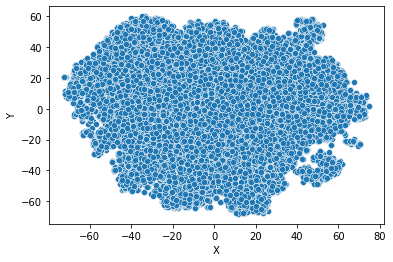

In [79]:
sns.scatterplot(x='X', y='Y', data=df_tsne, legend=None)

In [38]:
def single_model_and_plot(model, K, df, df_clusters, title, random_state=0):
    try:
        clustering = model(n_clusters=K, random_state=random_state).fit(df)
    except TypeError:
        clustering = model(n_clusters=K).fit(df)
    df_clusters['cluster'] = pd.Categorical(clustering.labels_)
    
    fig = plt.figure(figsize=(20,20))
    
#     plt.subplot(2,2,1)
#     sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=df_clusters, legend=None)
    plt.subplot(2,2,1)
    sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data=df_clusters, legend=None)
#     plt.subplot(2,2,3)
#     sns.scatterplot(x='MDS_X', y='MDS_Y', hue='cluster', style='cluster', data=df_clusters, legend=None)

#     gpca.legend(bbox_to_anchor=(1, 1))
#     gtsne.legend(bbox_to_anchor=(1, 1))
#     gmds.legend(bbox_to_anchor=(1, 1))

#     gpca.set_title('PCA')
#     gtsne.set_title('T-SNE')
#     gmds.set_title('MDS')
#     fig.suptitle('{} with {}'.format(title, clustering), fontsize=16)
#     plt.show()

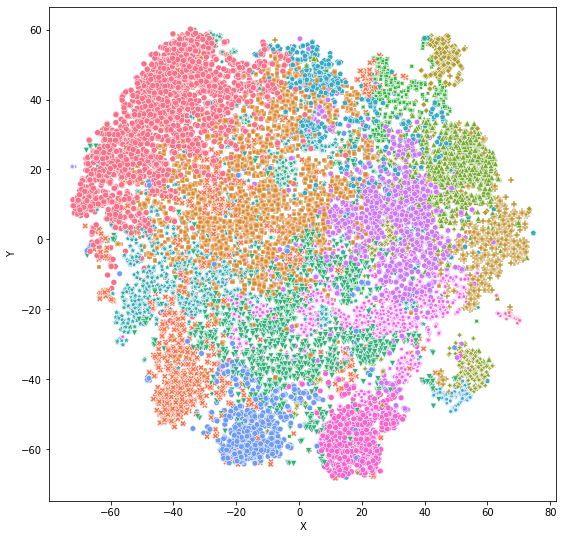

In [39]:
single_model_and_plot(AgglomerativeClustering, K=20, df=scaled_data, df_clusters=df_tsne, 
                      title='Clustering on scaled data', random_state=None)

## Evaluation

In [155]:
# Loop through models and score them
models = [KMeans, AgglomerativeClustering, Birch, GaussianMixture, AffinityPropagation, SpectralClustering, 
          DBSCAN, OPTICS]
metrics = [silhouette_score, davies_bouldin_score, calinski_harabasz_score]

models = [('KMeans', KMeans), , 
          ('SpectralClustering', SpectralClustering), ('Agglomerative', AgglomerativeClustering), 
          ('Birch', Birch), ('GaussianMixture', GaussianMixture)]
# models = [('GaussianMixture', GaussianMixture)]
metrics = [silhouette_score]

  0%|          | 0/3 [00:00<?, ?it/s]

AffinityPropagation


  0%|          | 0/3 [10:48:07<?, ?it/s]


ValueError: x and y must have same first dimension, but have shapes (2,) and (0,)

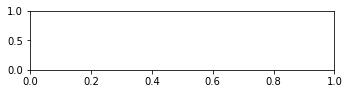

In [163]:
def model_evaluation(data):
    cluster_size = range(2, 4)    
    cols = 2
    rows = len(models)//2 + len(models)%2
    fig = plt.figure(figsize=(12,5))
    gs = plt.GridSpec(rows, cols)
    
    models_one_run = [('AffinityPropagation', AffinityPropagation), ('DBSCAN', DBSCAN), ('OPTICS', OPTICS)]
#     models_k = 
    
    for idx, model in enumerate(tqdm(models_one_run)):
        silhouette = []
        davies = []
        calinski = []
        print(model[0])
        
        try:
            clstr = model[1](random_state=0).fit(data)
            labels = clstr.labels_
        except:
            clstr = model[1]().fit(data)
            labels = clstr.labels_   
        
        
        
        i = idx%2
        j = idx//2
        plt.subplot(gs[j,i])
        plt.plot(cluster_size, silhouette, label='silhouette')
        plt.plot(cluster_size, davies, label='davies')
        plt.plot(cluster_size, calinski, label='calinski')
        plt.title(model[0])
        

#     for idx, model in enumerate(tqdm(models)):
#         silhouette = []
#         davies = []
#         calinski = []
#         print(model[0])
#         for k in tqdm(cluster_size):
#             if model[0] in ('KMeans', 'SpectralClustering'):
#                 clstr = model[1](n_clusters=k, random_state=0).fit(data)
#                 labels = clstr.labels_
#             elif model[0] in ('Agglomerative', 'Birch', 'DBSCAN', 'OPTICS'):
#                 clstr = model[1](n_clusters=k).fit(data)
#                 labels = clstr.labels_
#             elif model[0]=='GaussianMixture':
#                 clstr = model[1](n_components=k).fit(data)
#                 labels = clstr.predict(feats_df)
                
                
#             silhouette.append(silhouette_score(data, labels))
#             davies.append(davies_bouldin_score(data, labels))
#             calinski.append(calinski_harabasz_score(data, labels))
         
#         if model[0] in ('AffinityPropagation'):
#             clstr = model[1](random_state=0).fit(data)
#             labels = clstr.labels_
#             silhouette.append(silhouette_score(data, labels))
#             davies.append(davies_bouldin_score(data, labels))
#             calinski.append(calinski_harabasz_score(data, labels))
                
#         i = idx%2
#         j = idx//2
#         plt.subplot(gs[j,i])
#         plt.plot(cluster_size, silhouette, label='silhouette')
#         plt.plot(cluster_size, davies, label='davies')
#         plt.plot(cluster_size, calinski, label='calinski')
#         plt.title(model[0])
        
        

    plt.tight_layout()
    plt.show()
            
    return silhouette
model_evaluation(feats_df)

In [165]:
silhouette.append(silhouette_score(data, labels))
davies.append(davies_bouldin_score(data, labels))
calinski.append(calinski_harabasz_score(data, labels))

NameError: name 'silhouette' is not defined

# Similarity Approach

In [40]:
from sklearn.neighbors import NearestNeighbors

In [41]:
scaled_data
feats_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.612856,1.087184,-0.201775,0.996660,0.208011,0.192259,-0.913576,-0.473002,-0.007089,1.210086,-0.020760,-0.385630,0.590494
1,-1.181611,0.440106,-1.061919,-0.305130,-0.779607,-0.032644,-0.456511,1.291821,-0.187318,-0.100881,0.497542,1.926104,-1.768360
2,0.685865,0.417537,-0.259118,1.002980,-0.926207,0.063337,0.165333,-0.473291,-0.430553,0.596989,-0.908796,-0.457733,0.590494
3,-0.952022,-0.129984,-0.105293,-0.916527,0.349099,-0.458178,0.191017,1.129130,0.020639,-0.301443,0.570073,-0.151709,0.103746
4,-0.305220,0.094313,-2.714744,-0.113532,1.050391,-0.915264,-0.369455,0.168603,-0.485723,0.006686,0.868141,0.611446,-0.010782


# SKLearn Nearest Neighbors

In [44]:
nbrs = NearestNeighbors(n_neighbors=3).fit(scaled_data)
NN = nbrs.kneighbors(scaled_y)
# closest_vec = sacaled_data[nbrs.kneighbors(np.atleast_2d(y))[1][0,0]]
# closest_vec

In [57]:
df.loc[NN[1][0]]

,name,pid,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
2078,Good Feels,10078,0.620494,0.689645,4.829787,-6.613843,0.604255,0.074454,0.176513,0.060648,0.195173,0.572719,122.891974,221843.378723,3.970213
3887,Misc.,100887,0.626144,0.740845,5.195876,-6.047526,0.639175,0.066429,0.126209,0.033925,0.193714,0.577834,123.887361,227054.175258,3.979381
19505,walking,115505,0.632692,0.743308,5.092308,-6.391969,0.615385,0.088738,0.148979,0.008973,0.181932,0.575231,121.818277,234808.676923,3.969231


In [59]:
items = []
for track in playlists[2078]['tracks']:
    items.append(track['track_uri'].split("k:")[1])

In [61]:
user_id = sp.current_user()['id']
sp.user_playlist_create('1276348384', 'Hello World!', description='First ever personal Machine Learning Playlist')


{'collaborative': False,
 'description': 'First ever personal Machine Learning Playlist',
 'external_urls': {'spotify': 'https://open.spotify.com/playlist/6N6cLTS50hzSQfOBgJdQoO'},
 'followers': {'href': None, 'total': 0},
 'href': 'https://api.spotify.com/v1/playlists/6N6cLTS50hzSQfOBgJdQoO',
 'id': '6N6cLTS50hzSQfOBgJdQoO',
 'images': [],
 'name': 'Hello World!',
 'owner': {'display_name': 'David Hernandez',
  'external_urls': {'spotify': 'https://open.spotify.com/user/1276348384'},
  'href': 'https://api.spotify.com/v1/users/1276348384',
  'id': '1276348384',
  'type': 'user',
  'uri': 'spotify:user:1276348384'},
 'primary_color': None,
 'public': True,
 'snapshot_id': 'MSxhZjk5NjllMDk0NWI1Y2M3NzE4Mjc5YjEzYTE5ZDNjMDEwMTRlMTFi',
 'tracks': {'href': 'https://api.spotify.com/v1/playlists/6N6cLTS50hzSQfOBgJdQoO/tracks',
  'items': [],
  'limit': 100,
  'next': None,
  'offset': 0,
  'previous': None,
  'total': 0},
 'type': 'playlist',
 'uri': 'spotify:playlist:6N6cLTS50hzSQfOBgJdQoO'}

In [64]:
sp.playlist_add_items('6N6cLTS50hzSQfOBgJdQoO',items=items[:99])

{'snapshot_id': 'MywwYjBiNTE4MWQ1MzVjM2YyMzUyZWRjNzRjMzM4OGQ0OWQxOTBmZWMx'}

# Cosine Similarity

In [65]:
from scipy.spatial.distance import cdist

In [66]:
['cosine', 'euclidian', 'mahalanobis', 'canberra', 'chebyshev']

['cosine', 'euclidian', 'mahalanobis', 'canberra', 'chebyshev']

In [73]:
# Run similarity and select top 3 closests
simi = cdist(scaled_data, scaled_y, metric='cosine').argsort(axis=None)[0]
simi

7954

In [74]:
df.loc[simi]

name                Oldies but Goodies
pid                             104954
danceability                  0.665955
energy                        0.775341
key                            5.04545
loudness                      -5.93327
mode                          0.681818
speechiness                  0.0606182
acousticness                  0.136491
instrumentalness             0.0355639
liveness                      0.184595
valence                       0.696455
tempo                           123.09
duration_ms                     217712
time_signature                       4
Name: 7954, dtype: object

In [75]:
playlists[simi]

{'name': 'Oldies but Goodies',
 'collaborative': 'false',
 'pid': 104954,
 'modified_at': 1497484800,
 'num_tracks': 44,
 'num_albums': 43,
 'num_followers': 3,
 'tracks': [{'pos': 0,
   'artist_name': 'Gwen Stefani',
   'track_uri': 'spotify:track:26eOTllWPn7oKuDUJnsJwF',
   'artist_uri': 'spotify:artist:4yiQZ8tQPux8cPriYMWUFP',
   'track_name': 'The Sweet Escape',
   'album_uri': 'spotify:album:2uoNsOC1w0zkRp0TE2uzuI',
   'duration_ms': 246466,
   'album_name': 'The Sweet Escape'},
  {'pos': 1,
   'artist_name': 'Pitbull',
   'track_uri': 'spotify:track:3cHyrEgdyYRjgJKSOiOtcS',
   'artist_uri': 'spotify:artist:0TnOYISbd1XYRBk9myaseg',
   'track_name': 'Timber',
   'album_uri': 'spotify:album:2F7tejLHzTqFq2XLol9ZGy',
   'duration_ms': 204160,
   'album_name': 'Global Warming: Meltdown (Deluxe Version)'},
  {'pos': 2,
   'artist_name': 'Hot Chelle Rae',
   'track_uri': 'spotify:track:2i0AUcEnsDm3dsqLrFWUCq',
   'artist_uri': 'spotify:artist:6jTnHxhb6cDCaCu4rdvsQ0',
   'track_name': 'To

In [76]:
items = []
for track in playlists[simi]['tracks']:
    items.append(track['track_uri'].split("k:")[1])

In [77]:
sp.user_playlist_create('1276348384', 'Cosine Similarity', description='Playlist based on Cosine Similarity')

{'collaborative': False,
 'description': 'Playlist based on Cosine Similarity',
 'external_urls': {'spotify': 'https://open.spotify.com/playlist/0ZKfsEOgoICmxUEt9KJf26'},
 'followers': {'href': None, 'total': 0},
 'href': 'https://api.spotify.com/v1/playlists/0ZKfsEOgoICmxUEt9KJf26',
 'id': '0ZKfsEOgoICmxUEt9KJf26',
 'images': [],
 'name': 'Cosine Similarity',
 'owner': {'display_name': 'David Hernandez',
  'external_urls': {'spotify': 'https://open.spotify.com/user/1276348384'},
  'href': 'https://api.spotify.com/v1/users/1276348384',
  'id': '1276348384',
  'type': 'user',
  'uri': 'spotify:user:1276348384'},
 'primary_color': None,
 'public': True,
 'snapshot_id': 'MSxlZjE4ZWMzZjdkNzIxODc1OWVmYzUzNjVhM2JkNmJlYjk0Yzk2M2Yw',
 'tracks': {'href': 'https://api.spotify.com/v1/playlists/0ZKfsEOgoICmxUEt9KJf26/tracks',
  'items': [],
  'limit': 100,
  'next': None,
  'offset': 0,
  'previous': None,
  'total': 0},
 'type': 'playlist',
 'uri': 'spotify:playlist:0ZKfsEOgoICmxUEt9KJf26'}

In [78]:
sp.playlist_add_items('0ZKfsEOgoICmxUEt9KJf26',items=items[:99])

{'snapshot_id': 'Myw1YTk3YTkzMTAzM2ExYjMzYTYzYzJlYjg5NGNkMDA4MzgyZWM0MGYy'}

In [54]:
# Change the path to where your Spotify Million Playlist is located.
# The expected file structure is to have a data folder /data .csv files will be placed there.

path = 'data/spotify_million_playlist_dataset/data'

def loop_slices(path, num_slices=20):
    """
    Each slice is a .json file containing 1000 playlists i.e.: 1 slice is 1000 playlists 20 slices is: 20,000 playlists.
    Parameters:
        num_slices (int): Number of slices to return, max 1000.
        path (str): Path to the Spotify Million Playlist.
        
    Output:
        mpd_playlists (list): a list of dictionaries of all the playlists.
    """
    cnt=0
    mpd_playlists = []
    filenames = os.listdir(path)
    for filename in sorted(filenames):
        print(filename)
        cnt+=1
        if filename.startswith("mpd.slice.") and filename.endswith(".json"):
            fullpath = os.sep.join((path, filename))
            f = open(fullpath)
            js = f.read()
            f.close()
            current_slice = json.loads(js)
            
            # Create a list of all playlists
            for playlist in current_slice['playlists']:
                mpd_playlists.append(playlist)


            if cnt == num_slices:
                break
    return mpd_playlists

In [55]:
playlists = loop_slices(path, num_slices=20)



mpd.slice.0-999.json
mpd.slice.1000-1999.json
mpd.slice.10000-10999.json
mpd.slice.100000-100999.json
mpd.slice.101000-101999.json
mpd.slice.102000-102999.json
mpd.slice.103000-103999.json
mpd.slice.104000-104999.json
mpd.slice.105000-105999.json
mpd.slice.106000-106999.json
mpd.slice.107000-107999.json
mpd.slice.108000-108999.json
mpd.slice.109000-109999.json
mpd.slice.11000-11999.json
mpd.slice.110000-110999.json
mpd.slice.111000-111999.json
mpd.slice.112000-112999.json
mpd.slice.113000-113999.json
mpd.slice.114000-114999.json
mpd.slice.115000-115999.json


In [ ]:
playlists[1]

In [ ]:
l1 = [s1, s2, s3]
user = [s3, s2, s5]